In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal
from dotenv import load_dotenv
from pydantic import BaseModel,Field

In [6]:
load_dotenv()

True

In [107]:
model=ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [108]:
class Sentiment(BaseModel):
    sentiment:Literal["positive","negative"]=Field(description="Sentiment of the review")
    

In [109]:
Str_model=model.with_structured_output(Sentiment)

In [110]:
Str_model2=model.with_structured_output(Diagnosis_Schema)

In [111]:
prompt="what is the sentiment of this review -The software is to bad"
Str_model.invoke(prompt)

Sentiment(sentiment='negative')

In [112]:
class ReviewState(TypedDict):
    review:str
    sentiment:Literal["positive","negative"]
    diagnosis:dict
    response:str

In [113]:
def find_sentiment(state:ReviewState):
    prompt=f"what is the sentiment of this given review :{state['review']}"
    Senti=Str_model.invoke(prompt)
    return {"sentiment":Senti}

In [114]:
def check_sentiment(state:ReviewState)->Literal["positive_response","run_diagnosis"]:
    if state['sentiment']=="positive":
        return 'positive_response'
    else:
        return 'run_diagnosis'

In [115]:
def positive_response(state:ReviewState):
    prompt=f"""Write a warn thank-you message in response to this review:\n\n"{state['review']}",Also,kindly ask the user to leave feedback on our website.
"""
    out=model.invoke(prompt).content
    return {'response':out}

In [116]:
class Diagnosis_Schema(BaseModel):
    issue_type:Literal["UX","Performance","Bug","Support","Other"]=Field(description='The category issue mentioned in the review')
    tone:Literal["angry","frustrated","disapponinted","calm"]=Field(description='The emotional tone expressed by the user')
    urgency:Literal["low","medium","high"]=Field(description='How urgent or critical the issue appears to be')

In [117]:
def run_diagnosis(state:ReviewState):
    prompt=f"""Diagnose this negative review:\n\n{state['review']}\n"
    Return issue_type,tone and urgency"
"""
    out=Str_model2.invoke(prompt)
    return {'diagnosis':out.model_dump()}

In [118]:
def negative_response(state:ReviewState):
    diagnosis=state['diagnosis']
    prompt=f"""You are a support assistant.
    The user had a '{diagnosis['issue_type']},sounded'{diagnosis['tone']},and marked urgency {diagnosis['urgency']}'
    Write an empathetic,helpful resolution message
"""
    out=model.invoke(prompt).content
    return {'response':out}

In [119]:
graph=StateGraph(ReviewState)
graph.add_node("find_sentiment",find_sentiment)
graph.add_node("run_diagnosis",run_diagnosis)
graph.add_node("negative_response",negative_response)
graph.add_node("positive_response",positive_response)

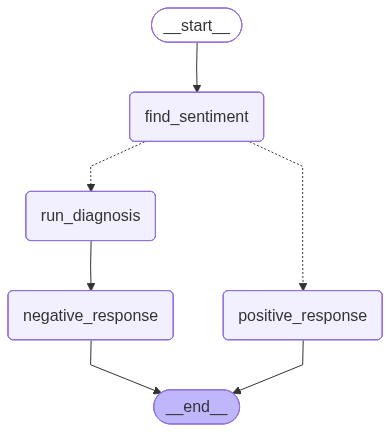

In [124]:
from IPython.display import Image
Image(wf.get_graph().draw_mermaid_png())

In [ ]:
graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_sentiment)
graph.add_edge('positive_response',END)
graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response',END)

In [121]:
wf=graph.compile()

In [123]:
intial_state={
   'review': "I've been using this app for about a month now,and I must say,the user interface is incredibly clean and intutive.Everything is exactly where you'd except it to be.It's rare to find something that just works without needing a tutorial.Great job to the design team"
}
wf.invoke(intial_state)

{'review': "I've been using this app for about a month now,and I must say,the user interface is incredibly clean and intutive.Everything is exactly where you'd except it to be.It's rare to find something that just works without needing a tutorial.Great job to the design team",
 'sentiment': Sentiment(sentiment='positive'),
 'diagnosis': {'issue_type': 'UX', 'tone': 'calm', 'urgency': 'low'},
 'response': 'Okay, I understand. It sounds like you were experiencing something related to UX, and based on your calm demeanor and low urgency, it seems like it wasn\'t a critical issue.\n\nHere\'s an empathetic and helpful resolution message I can offer:\n\n**Option 1 (General):**\n\n> "Thanks for reaching out! I understand you were experiencing something related to the UX. While it sounds like it wasn\'t urgent, I want to make sure everything is resolved.  Could you provide a little more detail about what you were encountering?  This will help me understand the situation and offer the best possi